In [30]:
# Dc = content distance, Ds = style distance
# minimizing the content/style distance with content/style image by gradient descent

In [31]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
# im = Image.open('images/sarthak')
# im.save('s_1.jpg',"JPEG")

png = Image.open('images/sarthak')
png.load() # required for png.split()

background = Image.new("RGB", png.size, (255, 255, 255))
background.paste(png, mask=png.split()[3]) # 3 is the alpha channel

background.save('foo.jpg', 'JPEG', quality=80)

In [33]:
imsize = 1024 if torch.cuda.is_available() else 1024 # use samll if no gpu

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name) 
    # fake batch dimension required to fit network's input dimensions ????????
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader('images/picasso.jpg')
content_img = image_loader('images/p.jpg')
print (style_img.size())
print (content_img.size())
assert style_img.size() == content_img.size(), "we need to import style and content images of the same size"

torch.Size([1, 3, 1024, 1024])
torch.Size([1, 3, 1024, 1024])


<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7FBE2668CB50>


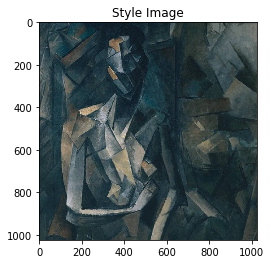

<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7FBE240D75D0>


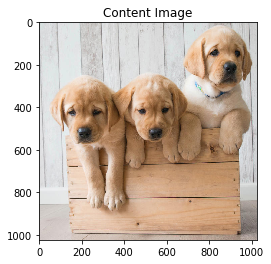

In [34]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    print (image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [35]:
# Content Loss
class ContentLoss(nn.Module):
    def __init__(self,target,):
        super(ContentLoss,self).__init__()
        self.target = target.detach()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error
    
    def forward(self,input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [36]:
# Style Loss

# Fxl * Fxl.T
def gram_matrix(input):
    # a=batch_size, b=number_feature_maps, c,d=dimensions of F_xl
    a,b,c,d = input.size()
    features = input.view(a*b,c*d)
    G = torch.mm(features, features.t())
    
    # normalize G
    return G.div(a*b*c*d)

class StyleLoss(nn.Module):    
    def __init__(self,target_feature):
        super(StyleLoss,self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self,input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G,self.target)
        return input

In [37]:
# TRANSFER LEARNING
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [38]:
cnn_normalization_mean = torch.tensor([0.485,0.456,0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229,0.224,0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self,mean,std):
        super(Normalization,self).__init__()
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)
        #neural net needs image tensor shape [Batch x Channels x H x W]
    
    def forward(self,img):
        return (img-self.mean)/self.std

In [39]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses
# content_layers_default = ['conv_4']
# style_layers_default = ['conv_1','conv_2','conv_3','conv_4','conv_5']

# def get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img, content_layers=content_layers_default, style_layers=style_layers_default):
#     cnn = copy.deepcopy(cnn)
#     normalization = Normalization(normalization_mean, normalization_std).to(device)
#     content_losses = []
#     style_losses = []
    
#     model = nn.Sequential(normalization)
    
#     i=0
#     for layer in cnn.children():
#         if isinstance(layer,nn.Conv2d):
#             i += 1
#             name = 'Conv_{}'.format(i)
        
#         elif isinstance(layer,nn.ReLU):
#             name = 'ReLU_{}'.format(i)
#             layer = nn.ReLU(inplace=False)
        
#         elif isinstance(layer,nn.MaxPool2d):
#             name = 'pool_{}'.format(i)
            
#         elif isinstance(layer,nn.BatchNorm2d):
#             name = 'batch_norm_{}'.format(i)
        
#         else:
#             raise RuntimeError('Unrecognized Layer: {}'.format(layer.__class__.__name__))
            
        
#         model.add_module(name,layer)
        
#         if name in content_layers:
#             target = model(content_img).detach()
#             content_loss = ContentLoss(target)
#             model.add_module("content_loss_{}".format(i), content_loss)
#             content_losses.append(content_loss)
            
#         if name in style_layers:
#             target_feature = model(style_img).detach()
#             style_loss = StyleLoss(target_feature)
#             model.add_module("style_loss_{}".format(i), style_loss)
#             print(style_loss)
#             style_losses.append(style_loss)
        
#     for i in range(len(model)-1, -1, -1):
#         if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
#             break
            
#     model = model[:(i+1)]
    
#     return model, style_losses, content_losses

<PIL.Image.Image image mode=RGB size=1024x1024 at 0x7FBE26223B10>


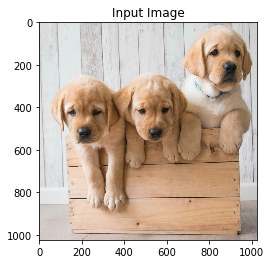

In [40]:
# INPUT IMAGE
input_img = content_img.clone()
plt.figure()
imshow(input_img, title="Input Image")

In [41]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()]) # just a new gradient descent algo
    return optimizer

In [42]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=80,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [ ]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img)
plt.figure()
imshow(output, title='Output Image')
plt.ioff()
plt.show()

Building the style transfer model..


In [ ]:
# chack the array output
# if run[0] % 1 == 0:
#             test_output = input_img.data.clamp_(0, 1)
#             name = 'Generated_images/test_' + str(run[0]) +'.png'
#             plt.imsave(name,test_output)